couple of functions to help us:

In [1]:
import sys
def print_info(data_structure):
    # Get the type of the data structure
    data_type = type(data_structure)
    
    # Get the size of the data structure in bytes
    size = sys.getsizeof(data_structure)
    
    # Print the type and size
    print(f"Type of data structure: {data_type}")
    print(f"Size of data structure: {size} bytes")



In [2]:
import pandas as pd

def print_dataframe_info(df):
    # Check if the input is a Pandas DataFrame
    if isinstance(df, pd.DataFrame):
        print(f"Type of data structure: {type(df)}")
        print(f"Dimensions of DataFrame: {df.shape} (rows, columns)")
    else:
        print("The provided data structure is not a Pandas DataFrame.")

# Example usage
data = {'col1': [1, 2], 'col2': [3, 4]}
df = pd.DataFrame(data)
print_dataframe_info(df)

Type of data structure: <class 'pandas.core.frame.DataFrame'>
Dimensions of DataFrame: (2, 2) (rows, columns)


import the movielens data and make it suitable to be fed into NN

max movie id:  13175 , max user id:  1000
Train Loader - First batch info:
Batch shape: torch.Size([64, 13175])
Batch type: torch.float32
Number of samples in batch: 64
Validation Loader - First batch info:
Batch shape: torch.Size([64, 13175])
Batch type: torch.float32
Number of samples in batch: 64
Test Loader - First batch info:
Batch shape: torch.Size([64, 13175])
Batch type: torch.float32
Number of samples in batch: 64


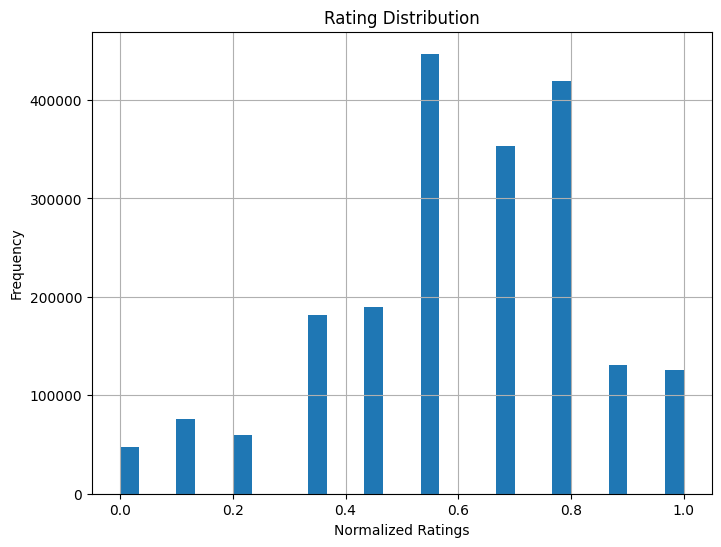

User 419's Ratings:
Jumanji (1995): 2.00
Grumpier Old Men (1995): 3.00
Waiting to Exhale (1995): 1.50
Heat (1995): 3.00
Tom and Huck (1995): 2.50
GoldenEye (1995): 2.00
American President, The (1995): 2.50
Dracula: Dead and Loving It (1995): 3.00
Balto (1995): 2.00
Casino (1995): 4.50
Sense and Sensibility (1995): 3.50
Four Rooms (1995): 2.00
Ace Ventura: When Nature Calls (1995): 2.50
Get Shorty (1995): 2.00
Copycat (1995): 2.00
Powder (1995): 2.00
Leaving Las Vegas (1995): 3.50
Persuasion (1995): 2.50
City of Lost Children, The (Cité des enfants perdus, La) (1995): 2.50
Shanghai Triad (Yao a yao yao dao waipo qiao) (1995): 3.00
Carrington (1995): 2.00
Dead Man Walking (1995): 3.50
Clueless (1995): 2.00
Richard III (1995): 3.00
Dead Presidents (1995): 2.50
Mortal Kombat (1995): 3.00
How to Make an American Quilt (1995): 2.00
Seven (a.k.a. Se7en) (1995): 3.00
Pocahontas (1995): 3.00
When Night Is Falling (1995): 3.50
Guardian Angel (1994): 3.50
Mighty Aphrodite (1995): 3.00
Lamerica (1

In [5]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch
import matplotlib.pyplot as plt


popularity_threshold = 50 
top_users = 1000  


ratings_data = pd.read_csv('ratings.csv', usecols=['userId', 'movieId', 'rating'])
movies_data = pd.read_csv('movies.csv', usecols=['movieId', 'title', 'genres'])
#loaded the data
#ratings_data is a (25000095, 3) (rows, columns) dataframe (all the reviws)
#movies_data is a (62423, 3) (rows, columns) (list of all movies)



# Select top users and movies
movie_popularity = ratings_data['movieId'].value_counts()
popular_movies = movie_popularity[movie_popularity >= popularity_threshold].index
top_users = ratings_data['userId'].value_counts().nlargest(top_users).index

#popular_movies and top_users are Pandas Index objects (hold the axis labels for the dataframes)

ratings_data = ratings_data[(ratings_data['movieId'].isin(popular_movies)) & (ratings_data['userId'].isin(top_users))]
#keep the ratings data that has the indices corresp to top users and popular moveis

user_ids = pd.factorize(ratings_data['userId'])[0] 
movie_ids = pd.factorize(ratings_data['movieId'])[0]
ratings_data['userId'] = user_ids
ratings_data['movieId'] = movie_ids
#print_dataframe_info(ratings_data)
#ratings_data is now (2031008, 3) (rows, columns) - dataframe with all reviews

max_user_id = user_ids.max() + 1  # +1 because index starts from 0
max_movie_id = movie_ids.max() + 1 
print("max movie id: ", max_movie_id, ", max user id: " , max_user_id )
# max movie id:  13175 , max user id:  1000

# normalize ratings (1-5 --> 0-1)
min_rating = ratings_data['rating'].min()
max_rating = ratings_data['rating'].max()
#print(min_rating, max_rating)
ratings_data['rating'] = (ratings_data['rating'] - min_rating) / (max_rating - min_rating)


# create the user-item matrix - compressed sparse row format,
# populared with values from ratings, column=user_ids, rows=movie_ids
user_item_matrix = csr_matrix(
    (ratings_data['rating'].values, (user_ids, movie_ids)),
    shape=(max_user_id, max_movie_id)
)


# Split the data
train_indices, test_indices = train_test_split(np.arange(user_item_matrix.shape[0]), test_size=0.2, random_state=42)
train_indices, val_indices = train_test_split(train_indices, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# create datasets: from the big user-item CSF matrix, based on the random indices
# for train,test,val
class CSRDataset(Dataset):
    def __init__(self, user_item_matrix, indices):
        self.user_item_matrix = user_item_matrix
        self.indices = indices

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        user_idx = self.indices[idx]
        dense_row = self.user_item_matrix[user_idx].toarray().squeeze(0)
        dense_tensor = torch.from_numpy(dense_row).float()
        return dense_tensor

train_dataset = CSRDataset(user_item_matrix, train_indices)
val_dataset = CSRDataset(user_item_matrix, val_indices)
test_dataset = CSRDataset(user_item_matrix, test_indices)
#each instane of CSRDataset contains a portion of the user-item CSR matrix, 
#relevant to either training, validation, testing, and some implementation 
#methods (which pytorch uses to access/iterate thru data)

# datasets are passed to pytorch dataloaders (automate process of splitting into batches)
batch_size = 64  # Adjust this as needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


#understand the dimensions of the data fed into the NN
# Assuming the DataLoader and dataset are correctly defined and imported
import torch
from torch.utils.data import DataLoader

# Create a function to print the data loader information
def print_loader_info(loader, name):
    # Iterate through the first batch to get size and content information
    for i, data in enumerate(loader):
        if i == 0:  # We only look at the first batch to get an idea
            print(f"{name} - First batch info:")
            print(f"Batch shape: {data.shape}")
            print(f"Batch type: {data.dtype}")
            print(f"Number of samples in batch: {data.size(0)}")  # Assuming the first dimension is the batch size
            break

# Assuming train_loader, val_loader, and test_loader have been defined as per your snippet
print_loader_info(train_loader, "Train Loader")
print_loader_info(val_loader, "Validation Loader")
print_loader_info(test_loader, "Test Loader")


# Plot the distribution of the data
plt.figure(figsize=(8, 6))
ratings_data['rating'].hist(bins=30)
plt.title('Rating Distribution')
plt.xlabel('Normalized Ratings')
plt.ylabel('Frequency')
plt.show()

# List the reviews of a random user
random_user_index = np.random.choice(train_indices)
random_user_data = user_item_matrix[random_user_index]
movie_indices = random_user_data.indices
ratings = random_user_data.data * (max_rating - min_rating) + min_rating  # Un-normalize the ratings

print(f"User {random_user_index}'s Ratings:")
for movie_idx, rating in zip(movie_indices, ratings):
    movie_id = movies_data.iloc[movie_idx]['movieId']
    title = movies_data[movies_data['movieId'] == movie_id]['title'].values[0]
    print(f"{title}: {rating:.2f}")


loading Netflix dataset and applying the same preprocessing steps

In [27]:
# Function to load Netflix ratings with progress monitoring
import os
def load_netflix_ratings_optimized(ratings_dir):
    ratings_list = []
    file_count = len([f for f in os.listdir(ratings_dir) if f.startswith('mv_') and f.endswith('.txt')])
    processed_files = 0
    for filename in os.listdir(ratings_dir):
        if filename.startswith('mv_') and filename.endswith('.txt'):
            movie_id = int(filename[3:10])  # Extract movie ID from filename
            with open(os.path.join(ratings_dir, filename), 'r') as file:
                lines = file.readlines()
                for line in lines[1:]:  # Skip the first line (movie ID)
                    user_id, rating, _ = line.strip().split(',')
                    ratings_list.append((int(user_id), movie_id, float(rating)))
                    if len(ratings_list) > 1000000:  # Write in chunks to manage memory
                        yield pd.DataFrame(ratings_list, columns=['userId', 'movieId', 'rating'])
                        ratings_list = []  # Reset list
            processed_files += 1
            print(f"Processed {processed_files}/{file_count} files ({(processed_files / file_count) * 100:.2f}%)")
    if ratings_list:
        yield pd.DataFrame(ratings_list, columns=['userId', 'movieId', 'rating'])

# Load all ratings into a DataFrame
netflix_ratings_dir = 'netflix'
netflix_ratings = pd.concat(load_netflix_ratings_optimized(netflix_ratings_dir), ignore_index=True)


Processed 1/2281 files (0.04%)
Processed 2/2281 files (0.09%)
Processed 3/2281 files (0.13%)
Processed 4/2281 files (0.18%)
Processed 5/2281 files (0.22%)
Processed 6/2281 files (0.26%)
Processed 7/2281 files (0.31%)
Processed 8/2281 files (0.35%)
Processed 9/2281 files (0.39%)
Processed 10/2281 files (0.44%)
Processed 11/2281 files (0.48%)
Processed 12/2281 files (0.53%)
Processed 13/2281 files (0.57%)
Processed 14/2281 files (0.61%)
Processed 15/2281 files (0.66%)
Processed 16/2281 files (0.70%)
Processed 17/2281 files (0.75%)
Processed 18/2281 files (0.79%)
Processed 19/2281 files (0.83%)
Processed 20/2281 files (0.88%)
Processed 21/2281 files (0.92%)
Processed 22/2281 files (0.96%)
Processed 23/2281 files (1.01%)
Processed 24/2281 files (1.05%)
Processed 25/2281 files (1.10%)
Processed 26/2281 files (1.14%)
Processed 27/2281 files (1.18%)
Processed 28/2281 files (1.23%)
Processed 29/2281 files (1.27%)
Processed 30/2281 files (1.32%)
Processed 31/2281 files (1.36%)
Processed 32/2281

lets create the user-item matrix that has to be completed. heres where i ran into the first, well, kinda obvious observation: we cant just put all the data into one matrix. we need a sparse matrix to feed the autoencoder. since we cant use a full desne user item matrix for such large datasets because of memory constraints, we will use a sparse matrix that is fed to the NN (autoencoders).
for this, we convert the dataframe into a sparsematrix format after splitting in train, test, validation

after running the code we have each batch containing data for 4 users, and each user has ratings data in a vector of length 53,514. This corresponds to the number of movies.
 this implies that the input layer of your autoencoder would have 53,514 neurons, which matches the number of features (movies) after preprocessing.

now, as per my planning, there are a couple things we need to do: define a model architecture (multiple layers of autoencoders:: encoder+latent space+decoder, perhaps layers that are not fully connected, pooling layers, dropout layers to reduce overfitting, perform batch normalization, everything we can to capture patterns), choose a lossfunction and incorporate ridge regression, choose optimizer, define forward and backward pass loops, implement residual connection (ResNets within autoencoder) or variational autoencoders and incorporate side info like metadata (but this will happen much later on in the project. 

In [29]:
print(netflix_ratings.head)
#netflix_movies = pd.read_csv('netflix\movie_titles.txt', header=None, names=['movieId', 'year', 'title'], delimiter=',')

def parse_netflix_movie_titles(filepath):
    movie_data = []
    with open(filepath, 'r', encoding='ISO-8859-1') as file:
        for line in file:
            # Split the line only on the first two commas
            movie_id, year, title = line.strip().split(',', 2)
            movie_data.append([int(movie_id), int(year), title])
    return pd.DataFrame(movie_data, columns=['movieId', 'year', 'title'])

# Use the custom function to load the movie titles
netflix_movies_path = 'netflix\movie_titles.txt'
netflix_movies = parse_netflix_movie_titles(netflix_movies_path)















# Apply filtering criteria
popularity_threshold = 50
top_user_limit = 1000  # Use a different variable name to store the number of top users

movie_popularity = netflix_ratings['movieId'].value_counts()
popular_movies = movie_popularity[movie_popularity >= popularity_threshold].index
top_user_indices = netflix_ratings['userId'].value_counts().nlargest(top_user_limit).index

netflix_ratings = netflix_ratings[(netflix_ratings['movieId'].isin(popular_movies)) & (netflix_ratings['userId'].isin(top_user_indices))]

# Factorize user and movie IDs
user_ids, _ = pd.factorize(netflix_ratings['userId'])
movie_ids, _ = pd.factorize(netflix_ratings['movieId'])
netflix_ratings['userId'] = user_ids
netflix_ratings['movieId'] = movie_ids

# Normalize ratings
min_rating = netflix_ratings['rating'].min()
max_rating = netflix_ratings['rating'].max()
netflix_ratings['rating'] = (netflix_ratings['rating'] - min_rating) / (max_rating - min_rating)

# Create the user-item matrix
max_user_id = user_ids.max() + 1
max_movie_id = movie_ids.max() + 1
user_item_matrix_netflix = csr_matrix(
    (netflix_ratings['rating'].values, (user_ids, movie_ids)),
    shape=(max_user_id, max_movie_id)
)

max_user_id = netflix_ratings['userId'].max() + 1
max_movie_id = netflix_ratings['movieId'].max() + 1
user_item_matrix_netflix = csr_matrix(
    (netflix_ratings['rating'].values, (netflix_ratings['userId'], netflix_ratings['movieId'])),
    shape=(max_user_id, max_movie_id)
)

# Split the data
train_indices, test_indices = train_test_split(np.arange(user_item_matrix_netflix.shape[0]), test_size=0.2, random_state=42)
train_indices, val_indices = train_test_split(train_indices, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Create datasets
train_dataset = CSRDataset(user_item_matrix_netflix, train_indices)
val_dataset = CSRDataset(user_item_matrix_netflix, val_indices)
test_dataset = CSRDataset(user_item_matrix_netflix, test_indices)

# Create dataloaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

plt.figure(figsize=(8, 6))
netflix_ratings['rating'].hist(bins=30)
plt.title('Rating Distribution for Netflix Dataset')
plt.xlabel('Normalized Ratings')
plt.ylabel('Frequency')
plt.show()

import numpy as np

# Select a random user from the training indices
random_user_index = np.random.choice(train_indices)
random_user_data = user_item_matrix_netflix[random_user_index]
movie_indices = random_user_data.indices
ratings = random_user_data.data * (max_rating - min_rating) + min_rating  # Un-normalize the ratings

# Print the random user's ratings
print(f"User {random_user_index}'s Ratings:")
for movie_idx, rating in zip(movie_indices, ratings):
    movie_id = movie_id_map[movie_idx]  # Retrieve original movie ID
    title = netflix_movies[netflix_movies['movieId'] == movie_id]['title'].values[0]
    print(f"{title}: {rating:.2f}")



<bound method NDFrame.head of            userId  movieId  rating
0         1488844        1     3.0
1          822109        1     5.0
2          885013        1     4.0
3           30878        1     4.0
4          823519        1     3.0
...           ...      ...     ...
11825513   394793     2281     3.0
11825514  2634967     2281     1.0
11825515   822391     2281     1.0
11825516  2133893     2281     1.0
11825517  1922916     2281     3.0

[11825518 rows x 3 columns]>


ValueError: invalid literal for int() with base 10: 'NULL'

In [5]:
import torch
from torch import nn

class Autoencoder(nn.Module): #all custom NN models in pytorch extend this Module class
    def __init__(self, input_dim, hidden_dims, activation_fn=nn.ReLU()):
        super(Autoencoder, self).__init__()
        # Encoder
        encoder_layers = [] #create a list of layers, starting with the input and then
        previous_dim = input_dim
        for hidden_dim in hidden_dims: #progressively add layers w decreasing size
            encoder_layers.append(nn.Linear(previous_dim, hidden_dim)) 
            #create a fully connected layer between prev dim and current dim
            encoder_layers.append(activation_fn)
            #after each layer, the activation function is appended. ReLU introduces nonlinearities
            previous_dim = hidden_dim
        self.encoder = nn.Sequential(*encoder_layers)
        
        # decodet just mirrors encoder structure, in reverse
        decoder_layers = []
        hidden_dims.reverse()
        for hidden_dim in hidden_dims[1:]:
            decoder_layers.append(nn.Linear(previous_dim, hidden_dim))
            decoder_layers.append(activation_fn)
            previous_dim = hidden_dim
        decoder_layers.append(nn.Linear(previous_dim, input_dim))  # Last layer to output
        self.decoder = nn.Sequential(*decoder_layers) 
        #create container modules that execute each layer, in order
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    #the dimenision of latent space is a hyperparameter that we need to choose
    #too large and compression is less meaningfuk, too small and it doesnt capture necessary info
    #we will try different sizes and measure impact on performance (reconstruction error)

    #the same tuning goes for input dimension and number of hidden layers. tho the input
    #dimension directly corresponds to size of each input array that we feed into
    #network (i.e the no of items/no of users)

    #tuning no of hidden layers/their dimensions: we will experiment 
    #we gonna use reconstruction error to evaluate how autoencoder performs with diff
    #architecutres. overfitting can be spotted if training error decreases
    #but validation error doesnt improve/worsens
    #techniques like k fold cross valiadtion can provide more robust insights

the encoder compresses data into smaller dense representation (latent space), the network funnels high dim data into low dim (layers decrease in size) - retain essential info 
decoder reconstructs original input data as close as possible from the compressed form created by encoder (expand the data back from latent space)
(see implementation above)

we use MSE for reconstruction loss and L@ regularization directly into loss function

In [6]:
def custom_loss_function(output, target, model, regularization_strength):
    reconstruction_loss_mae = nn.L1Loss()(output, target)
    reconstruction_loss_mse = nn.MSELoss()(output, target)
    l2_penalty = sum(p.pow(2.0).sum() for p in model.parameters())
    mse_loss_regularized = reconstruction_loss_mse + regularization_strength * l2_penalty
    mae_loss_regularized = reconstruction_loss_mae  # Usually, regularization is not applied to MAE

    # Choose one of the losses for backpropagation
    loss_for_backprop = mse_loss_regularized
    return loss_for_backprop


In [7]:
def simple_loss_function(output, target):
    mse_loss = nn.MSELoss()(output, target)
    mae_loss = nn.L1Loss()(output, target)
    return  mse_loss
# This makes the evaluation focused strictly on the
# reconstruction loss, which is more reflective of how
# the model will perform in practice without the influence 
# of training-specific regularizations. (for validation and test only)

DEFINE MODEL
and we choose an optimizer 
and regulariz term

In [8]:
model = Autoencoder(input_dim=max_movie_id, hidden_dims=[4096,2048,1024])
regularization_strength = 0
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# Regularization strength for L2 penalty



and then we define the forward and backward pass loops to train the autoencoder (for now just the autoencoder, later, it will be a more complicated NN)

In [9]:
def train_model(model, train_loader, optimizer, regularization_strength):
    model.train() #This is particularly important for models 
    #that have different behaviors during training vs. testing 
    #(e.g., models with dropout layers or batch normalization).
    epoch_losses = []
     #each epoch = full pass over entire training dataset
        #we iterate over the no of epochs we want to train the model
    total_loss = 0
    for inputs in train_loader: #we iterate over a batch of data provided by train_loader
            #each onput is a tensor consisting of (batch_size) arrays, each*
            #consisting of 13175 elements 
            optimizer.zero_grad() #reset gradients of model parameters (otherwise they accumulate 
            #with the ones from prev batches)
            outputs = model(inputs) #feed input features through models (forward pass) -> 
            #get preducted outputs
            #loss = custom_loss_function(outputs, inputs, model, regularization_strength)
            loss=simple_loss_function(outputs,inputs)
            #see how well outputs match inputs + regularization term for overfitting
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
    average_loss = total_loss / len(train_loader)
    print("train loss: ", average_loss)
    return average_loss
    

In [10]:
# Define the number of epochs to train
epochs = 1

# Call the training function
#train_model(model, train_loader, optimizer, regularization_strength)


make predictions and visualize training loss

In [11]:
def validate_model(model, val_loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for inputs in val_loader:
            outputs = model(inputs)
            loss = simple_loss_function(outputs, inputs)
            total_loss += loss.item()
    average_loss = total_loss / len(val_loader)
    print("Validation Loss:", average_loss)
    return average_loss

def test_model(model, test_loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for inputs in test_loader:
            outputs = model(inputs)
            loss = simple_loss_function(outputs, inputs)
            total_loss += loss.item()
    average_loss = total_loss / len(test_loader)
    print("Test Loss:", average_loss)
    return average_loss


In [14]:
import matplotlib.pyplot as plt

def plot_losses(training_losses, validation_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(training_losses, label='Training Loss')
    plt.plot(validation_losses, label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


In [13]:
# Define the number of epochs
epochs = 20

# Main training and evaluation loop
training_losses = []
validation_losses = []

for epoch in range(epochs):
    training_loss = train_model(model, train_loader, optimizer, regularization_strength)  # Train for one epoch
    training_losses.append(training_loss)  # Append the average training loss after each epoch
    validation_loss = validate_model(model, val_loader)  # Validate after each epoch
    validation_losses.append(validation_loss)  # Append the validation loss

# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), training_losses, label='Training Loss')
plt.plot(range(1, epochs+1), validation_losses, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Final evaluation on the test set
final_test_loss = test_model(model, test_loader)  # Final evaluation on test set
print("Final Test Loss:", final_test_loss)


train loss:  0.06621908731758594
Validation Loss: 0.06073989067226648
train loss:  0.049546987563371656
Validation Loss: 0.043867540545761585
train loss:  0.040748699009418486
Validation Loss: 0.043323054909706116
train loss:  0.03996322527527809
Validation Loss: 0.042354634031653404
train loss:  0.03963841311633587
Validation Loss: 0.04155475087463856
train loss:  0.038107845559716226
Validation Loss: 0.03976055886596441
train loss:  0.03656386509537697
Validation Loss: 0.03929696697741747
train loss:  0.03592051826417446
Validation Loss: 0.03854211699217558
train loss:  0.0354213897138834
Validation Loss: 0.038098474964499474
train loss:  0.03489405922591686
Validation Loss: 0.03757119830697775
train loss:  0.03428779654204846
Validation Loss: 0.03706651832908392
train loss:  0.03425617292523384
Validation Loss: 0.036860731430351734
train loss:  0.03367332983762026
Validation Loss: 0.036487722769379616
train loss:  0.033044012077152726
Validation Loss: 0.036197301000356674
train loss

KeyboardInterrupt: 

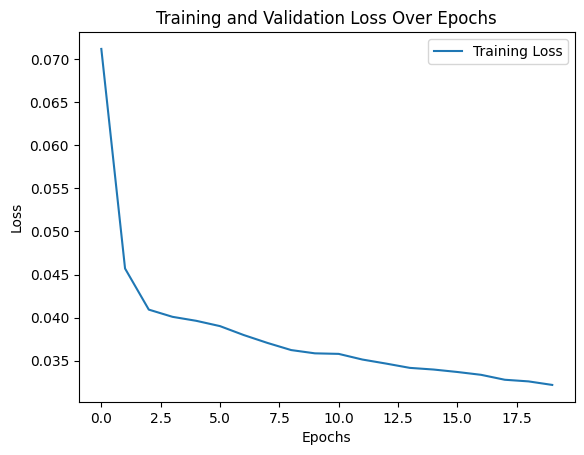

In [ ]:
import matplotlib.pyplot as plt

def plot_learning_curves(training_losses, validation_losses):
    plt.plot(training_losses, label='Training Loss')
    #plt.plot(validation_losses, label='Validation Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Example usage:
plot_learning_curves(training_losses, validation_losses)


In [ ]:

# Predict ratings for a single user
# Predict ratings for a single user
def predict_ratings(model, user_dense_tensor):
    # Ensure the tensor is in the right shape [1, number_of_movies]
    if user_dense_tensor.ndim == 1:
        user_dense_tensor = user_dense_tensor.unsqueeze(0)
    
    # Get predictions from the model
    with torch.no_grad():
        predicted_dense_tensor = model(user_dense_tensor)
    return predicted_dense_tensor.numpy()


index_to_movieId = {idx: movieId for idx, movieId in enumerate(ratings_data['movieId'].unique())}

# Function to map predicted movie indices to original movie titles
def map_indices_to_movie_titles(indices):
    movie_ids = [index_to_movieId[idx] for idx in indices]
    titles = movies_data[movies_data['movieId'].isin(movie_ids)]['title'].values
    return titles

def get_recommendations(user_predictions, k=10):
    # Sort predictions and get top k indices
    recommended_indices = user_predictions.argsort()[-k:][::-1]
    # Map indices to movie titles using the mapping function
    recommended_titles = map_indices_to_movie_titles(recommended_indices)
    return recommended_titles

random_user_index = np.random.choice(len(val_dataset))
user_dense_tensor = val_dataset[random_user_index]
user_predictions = predict_ratings(model, user_dense_tensor)
recommended_movies = get_recommendations(user_predictions.squeeze(), k=10)
print(f"Top 10 recommendations for user {654}: {recommended_movies}")





Top 10 recommendations for user 654: ['Star Trek II: The Wrath of Khan (1982)' 'Orgazmo (1997)'
 'Jerry Springer: Ringmaster (1998)' 'Hairspray (1988)'
 'Magnificent Seven, The (1960)' 'Little Man Tate (1991)'
 'Queen of the Damned (2002)' 'Valmont (1989)' 'Chosen, The (1981)'
 'Q & A (1990)']
